In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 13.6 MB/s 
     |████████████████████████████████| 101 kB 14.7 MB/s 
     |████████████████████████████████| 6.6 MB 13.7 MB/s 
     |████████████████████████████████| 596 kB 58.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

video_path =  '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/titanic.mp4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

In [ ]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

In [ ]:
v_cap = cv2.VideoCapture(video_path)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))


class FaceDetector(object):
    """
    Face detector class
    """
      
    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.extractor = AutoFeatureExtractor.from_pretrained("Rajaram1996/FacialEmoRecog")
        self.emotion_model = AutoModelForImageClassification.from_pretrained("Rajaram1996/FacialEmoRecog")
        self.emotion_model.eval()
        self.soft_max = torch.nn.Softmax(dim=0)
        self.faces = []
        self.face_image_limit = 130
        self.frames = []


    def predict_emotion(self, image_num):

        inputs = self.extractor(self.faces[image_num], return_tensors="pt")

        with torch.no_grad():
            logits = self.emotion_model(**inputs).logits

        variances = self.soft_max(logits[0])

        # model predicts one of the 1000 ImageNet classes
        predicted_label = variances.argmax(-1).item()
        
        print(plt.imshow(self.faces[image_num]))
        print(f'\nResult {self.emotion_model.config.id2label[predicted_label]} {variances[predicted_label]*100:.4}%')

        for i in range(len(variances)):
            print(f'{self.emotion_model.config.id2label[i]} {variances[i]*100:.4}%')


    def run(self):
        batch_size = 32

        # for _ in tqdm(range(v_len)):
        for frame_num in tqdm(range(200)):

            if frame_num % 6 == 0:
                # Load frame
                success, frame = v_cap.read()
                if not success:
                    continue
                    
                # Add to batch
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                self.frames.append(frame)
                
                # When batch is full, detect faces and reset batch list
                if len(self.frames) >= batch_size:
                    
                    try:
                        batch_boxes, _, batch_landmarks = self.mtcnn.detect(self.frames, landmarks=True)

                        for boxes, landmarks, frame in zip(batch_boxes, batch_landmarks, self.frames):
                            
                            # several faces in one frame
                            for box, landmark in zip(boxes, landmarks):
                                face_image = frame.crop((int(box[0]), int(box[1]), int(box[2]), int(box[3])))

                                # take faces more than <face_image_limit> pixels in one of the dims
                                if face_image.size[0] > self.face_image_limit and face_image.size[1] > self.face_image_limit:
                                    self.faces.append(face_image)
                        
                    except:
                        pass

        v_cap.release()
        cv2.destroyAllWindows()

      

In [ ]:
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
fcd.run()

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

AxesImage(54,36;334.8x217.44)
anger 15.76%
contempt 7.644%
disgust 8.893%
fear 16.59%
happy 6.098%
neutral 16.7%
sadness 20.25%
surprise 8.066%

Result sadness 20.25%


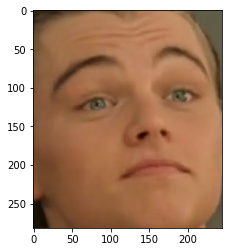

In [ ]:
fcd.predict_emotion(20)

In [ ]:
# pic_box = plt.figure(figsize=(25,100))

# for i, picture in enumerate(fcd.faces):
#     pic_box.add_subplot(len(fcd.faces)//5+2,5,i+1)
#     plt.imshow(picture)
#     plt.title(picture.size, x=1.5, y=0)

#     plt.axis('off')

# plt.show()    